In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = [15, 8]

In [3]:
data1 = pd.read_csv('rds_cpu_utilization_cc0c53.csv')
data2 = pd.read_csv('rds_cpu_utilization_e47b3b.csv')
data3 = pd.read_csv('ec2_cpu_utilization_ac20cd.csv')

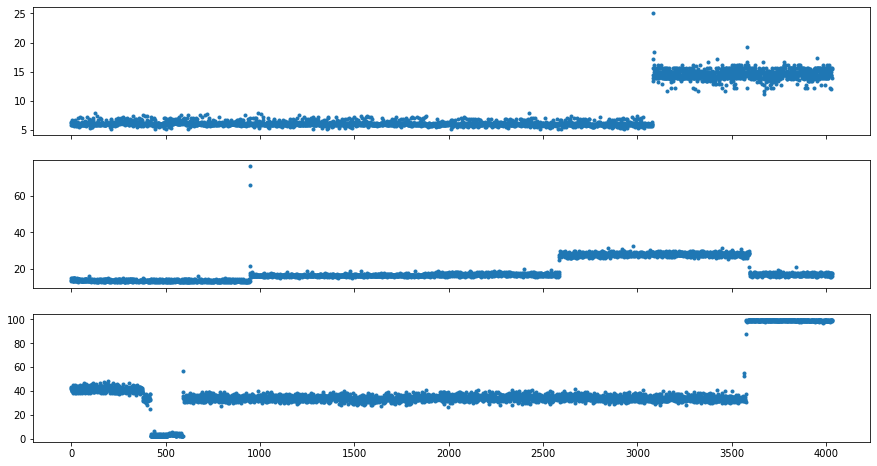

In [4]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex = True)

ax0.scatter(data1.index, data1.value, marker='.')
ax1.scatter(data2.index, data2.value, marker='.')
ax2.scatter(data3.index, data3.value, marker='.')

In [5]:
def st_scaler(data):
    scaler = StandardScaler()
    data_sc = data.copy()
    data_sc['value'] = scaler.fit_transform(data['value'].values.reshape(-1, 1))
    return data_sc

In [6]:
data1_sc, data2_sc, data3_sc = st_scaler(data1), st_scaler(data2), st_scaler(data3)

In [7]:
def train_test_split(data):
    split = int(0.8*len(data))
    train = data[:split]
    valid = data[split:]
    valid.reset_index(drop=True, inplace=True)
    return train, valid

In [8]:
train1, valid1 = train_test_split(data1_sc)
train2, valid2 = train_test_split(data2_sc)
train3, valid3 = train_test_split(data3_sc)

In [9]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error as mse

In [10]:
def calculate_prediction_errors(input_data, prediction_column_name):
    return (abs(input_data['value']-input_data[prediction_column_name]))

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import AveragePooling1D, MaxPool1D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

import os

In [12]:
def makeXy(data, num_timesteps):
    X = []
    y = []
    for i in range(num_timesteps, data.shape[0]):
        X.append(list(data.loc[i-num_timesteps:i-1]))
        y.append(data.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [13]:
X_train1, y_train1 = makeXy(train1['value'], 10)
X_train2, y_train2 = makeXy(train2['value'], 10)
X_train3, y_train3 = makeXy(train3['value'], 10)

X_val1, y_val1 = makeXy(valid1['value'], 10)
X_val2, y_val2 = makeXy(valid2['value'], 10)
X_val3, y_val3 = makeXy(valid3['value'], 10)

In [14]:
X_full1, y_full1 = makeXy(data1_sc['value'], 10)
X_full2, y_full2 = makeXy(data2_sc['value'], 10)
X_full3, y_full3 = makeXy(data3_sc['value'], 10)

X_full1 = X_full1.reshape((X_full1.shape[0], X_full1.shape[1], 1))
X_full2 = X_full2.reshape((X_full2.shape[0], X_full2.shape[1], 1))
X_full3 = X_full3.reshape((X_full3.shape[0], X_full3.shape[1], 1))

In [15]:
X_train1, X_val1 = X_train1.reshape((X_train1.shape[0], X_train1.shape[1], 1)),\
                 X_val1.reshape((X_val1.shape[0], X_val1.shape[1], 1))
X_train2, X_val2 = X_train2.reshape((X_train2.shape[0], X_train2.shape[1], 1)),\
                 X_val2.reshape((X_val2.shape[0], X_val2.shape[1], 1))
X_train3, X_val3 = X_train3.reshape((X_train3.shape[0], X_train3.shape[1], 1)),\
                 X_val3.reshape((X_val3.shape[0], X_val3.shape[1], 1))

In [16]:
model1 = Sequential()
model1.add(Conv1D(64, 3, strides=1, use_bias=True, input_shape=(10, 1)))
model1.add(BatchNormalization())
model1.add(MaxPool1D(pool_size=3, strides=1))
model1.add(Flatten())
model1.add(Dense(1, activation='linear'))
model1.compile(loss='mean_absolute_error', optimizer='adam')

model2 = Sequential()
model2.add(Conv1D(64, 3, strides=1, use_bias=True, input_shape=(10, 1)))
model2.add(BatchNormalization())
model2.add(MaxPool1D(pool_size=3, strides=1))
model2.add(Flatten())
model2.add(Dense(1, activation='linear'))
model2.compile(loss='mean_absolute_error', optimizer='adam')

model3 = Sequential()
model3.add(Conv1D(64, 3, strides=1, use_bias=True, input_shape=(10, 1)))
model2.add(BatchNormalization())
model3.add(MaxPool1D(pool_size=3, strides=1))
model3.add(Flatten())
model3.add(Dense(1, activation='linear'))
model3.compile(loss='mean_absolute_error', optimizer='adam')

In [17]:
save_weights_at1 = os.path.join('keras_models_main1', 'weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best1 = ModelCheckpoint(save_weights_at1, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', period=1)

save_weights_at2 = os.path.join('keras_models_main2', 'weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best2 = ModelCheckpoint(save_weights_at2, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', period=1)

save_weights_at3 = os.path.join('keras_models_main3', 'weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best3 = ModelCheckpoint(save_weights_at3, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', period=1)

In [18]:
model1.fit(x=X_train1, y=y_train1, batch_size=16, epochs=50, verbose=0, callbacks=[save_best1], 
                              validation_data=(X_val1, y_val1), shuffle=True)
model2.fit(x=X_train2, y=y_train2, batch_size=16, epochs=50, verbose=0, callbacks=[save_best2], 
                              validation_data=(X_val2, y_val2), shuffle=True)
model3.fit(x=X_train3, y=y_train3, batch_size=16, epochs=50, verbose=0, callbacks=[save_best3], 
                              validation_data=(X_val3, y_val3), shuffle=True)

In [19]:
best_model1 = load_model(os.path.join('keras_models_main1', 'weights.41-0.1721.hdf5'))
best_model2 = load_model(os.path.join('keras_models_main2', 'weights.46-0.1104.hdf5'))
best_model3 = load_model(os.path.join('keras_models_main3', 'weights.08-0.0598.hdf5'))

In [20]:
preds1_train = best_model1.predict(X_train1)
preds2_train = best_model2.predict(X_train2)
preds3_train = best_model2.predict(X_train3)

preds1_train = preds1_train.reshape(preds1_train.shape[0], )
preds2_train = preds2_train.reshape(preds2_train.shape[0], )
preds3_train = preds3_train.reshape(preds3_train.shape[0], )
train1['cnn_pred'] = 0
train1['cnn_pred'][10:] = preds1_train
train2['cnn_pred'] = 0
train2['cnn_pred'][10:] = preds2_train
train3['cnn_pred'] = 0
train3['cnn_pred'][10:] = preds3_train

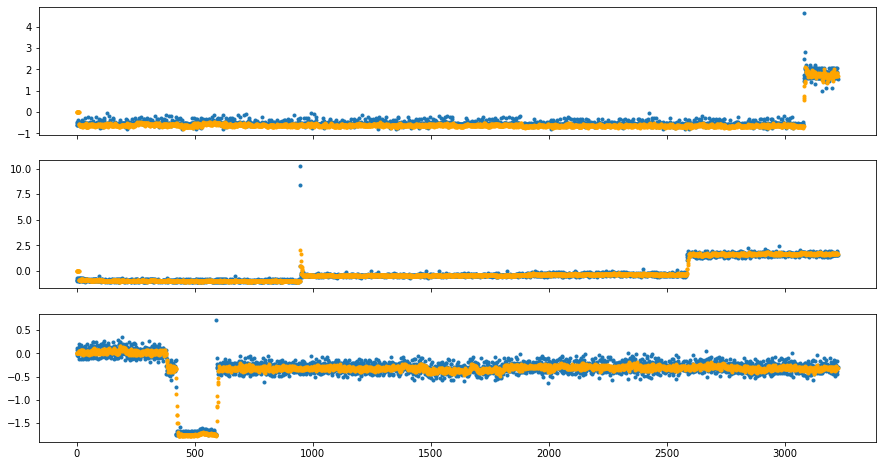

In [21]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex = True)

ax0.scatter(train1.index, train1.value, marker='.')
ax0.scatter(train1.index, train1.cnn_pred, marker = '.', color='orange')

ax1.scatter(train2.index, train2.value, marker='.')
ax1.scatter(train2.index, train2.cnn_pred, marker = '.', color='orange')

ax2.scatter(train3.index, train3.value, marker='.')
ax2.scatter(train3.index, train3.cnn_pred, marker = '.', color='orange')

In [22]:
from tensorflow.keras.layers import GRU

In [23]:
gru_model1 = Sequential()
gru_model1.add(GRU(64, input_shape=(10,1), return_sequences=True))
gru_model1.add(GRU(32, input_shape=(10,64), return_sequences=False))
gru_model1.add(Dense(1, activation='linear'))
gru_model1.compile(loss='mean_absolute_error', optimizer='adam')

gru_model2 = Sequential()
gru_model2.add(GRU(64, input_shape=(10,1), return_sequences=True))
gru_model2.add(GRU(32, input_shape=(10,64), return_sequences=False))
gru_model2.add(Dense(1, activation='linear'))
gru_model2.compile(loss='mean_absolute_error', optimizer='adam')

gru_model3 = Sequential()
gru_model3.add(GRU(64, input_shape=(10,1), return_sequences=True))
gru_model3.add(GRU(32, input_shape=(10,64), return_sequences=False))
gru_model3.add(Dense(1, activation='linear'))
gru_model3.compile(loss='mean_absolute_error', optimizer='adam')

In [24]:
gru_save_weights_at1 = os.path.join('keras_models_gru1', 'weights.{epoch:02d}-{val_loss:.4f}.hdf5')
gru_save_best1 = ModelCheckpoint(gru_save_weights_at1, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', period=1)

gru_save_weights_at2 = os.path.join('keras_models_gru2', 'weights.{epoch:02d}-{val_loss:.4f}.hdf5')
gru_save_best2 = ModelCheckpoint(gru_save_weights_at2, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', period=1)

gru_save_weights_at3 = os.path.join('keras_models_gru3', 'weights.{epoch:02d}-{val_loss:.4f}.hdf5')
gru_save_best3 = ModelCheckpoint(gru_save_weights_at3, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', period=1)

In [25]:
gru_model1.fit(x=X_train1, y=y_train1, batch_size=16, epochs=30, verbose=0, callbacks=[gru_save_best1], 
                              validation_data=(X_val1, y_val1), shuffle=True)
gru_model2.fit(x=X_train2, y=y_train2, batch_size=16, epochs=30, verbose=0, callbacks=[gru_save_best2], 
                              validation_data=(X_val2, y_val2), shuffle=True)
gru_model3.fit(x=X_train3, y=y_train3, batch_size=16, epochs=30, verbose=0, callbacks=[gru_save_best3], 
                              validation_data=(X_val3, y_val3), shuffle=True)

In [27]:
gru_best_model1 = load_model(os.path.join('keras_models_gru1', 'weights.22-0.1315.hdf5'))
gru_best_model2 = load_model(os.path.join('keras_models_gru2', 'weights.24-0.1049.hdf5'))
gru_best_model3 = load_model(os.path.join('keras_models_gru3', 'weights.01-0.6007.hdf5'))

In [28]:
gru_preds1_train = gru_best_model1.predict(X_train1)
gru_preds2_train = gru_best_model2.predict(X_train2)
gru_preds3_train = gru_best_model2.predict(X_train3)

gru_preds1_train = gru_preds1_train.reshape(gru_preds1_train.shape[0], )
gru_preds2_train = gru_preds2_train.reshape(gru_preds2_train.shape[0], )
gru_preds3_train = gru_preds3_train.reshape(gru_preds3_train.shape[0], )
train1['gru_pred'] = 0
train1['gru_pred'][10:] = gru_preds1_train
train2['gru_pred'] = 0
train2['gru_pred'][10:] = gru_preds2_train
train3['gru_pred'] = 0
train3['gru_pred'][10:] = gru_preds3_train

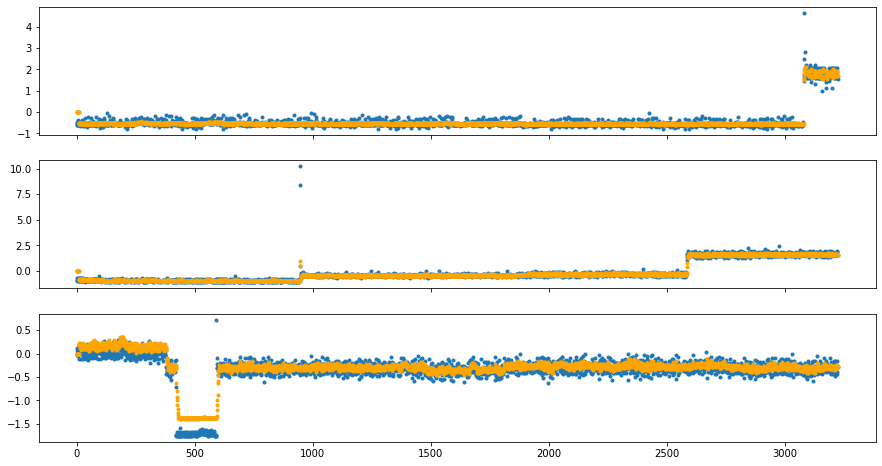

In [29]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex = True)

ax0.scatter(train1.index, train1.value, marker='.')
ax0.scatter(train1.index, train1.gru_pred, marker = '.', color='orange')

ax1.scatter(train2.index, train2.value, marker='.')
ax1.scatter(train2.index, train2.gru_pred, marker = '.', color='orange')

ax2.scatter(train3.index, train3.value, marker='.')
ax2.scatter(train3.index, train3.gru_pred, marker = '.', color='orange')